# 1. Load data

In [1]:
import pandas as pd

df = pd.read_pickle("data/final_data.pkl")

# Set some pandas options for viewing datasets
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None


# df[df['name'] == 'Erling Haaland'].head()

# 2. Linear programming model - functions

Now we finally build the LP model. I firstly select the 15 players for the initial squad and then the 11 players starting squad. 

Initial squad rules:
- Max 1000 cost.
- Exactly 15 players.
- Max 3 players from the same team.
- 2 GKs
- 5 DEFs
- 5 MIDs
- 3 FWDs

Final 11 squad rules:
- Exactly 11 players
- 1 GK
- 3 +
- 1 +

In [2]:
# Linear programming model
import pulp

def select_initial_squad(df: pd.DataFrame, optimize_for="total_points", return_team=False):
    """
    Selecting the initial squad consisting of 15 players (2 GK, 5 DEF, 5 MID, 3 FWD).
    Consting up to 1000 (100 mil.). Containing maximum of 3 players from a particular team.
    
    Optionally a metric to optimize for can be chosen.
    """

    df.reset_index(inplace=True, drop=True)
    num_players = len(df)
    model = pulp.LpProblem("Squad_selection_FPL_initial", pulp.LpMaximize)
    # Binary variable denoting if a player is selected or not
    decisions = [
        pulp.LpVariable(f"x{i}", lowBound=0, upBound=1, cat="Integer")
        for i in range(num_players)
    ]

    # Objective function
    model += (
        sum(
            decisions[i]
            * (
                df["xP_inter"][i]
                + df["expected_goals"][i]
                + df["expected_assists"][i]
                + df["expected_goal_involvements"][i]
                - df["expected_goals_conceded"][i]
                + df["rolling_total_points_3gw"][i]
                - df['fix_difficulty'][i]
            )
            for i in range(num_players)
        ),
        "Objective function",
    )

    # Cost constraint
    model += sum(decisions[i] * df["value"][i] for i in range(num_players)) <= 1000

    # Total team size
    model += sum(decisions) == 15 

    # Number of players from 1 team constraint
    for team in df["team"].unique():
        model += sum(decisions[i] for i in range(num_players) if df["team"][i] == team) <= 3

    # Player positions constraints
    model += sum(decisions[i] for i in range(num_players) if df["position"][i] == "GK") == 2
    model += sum(decisions[i] for i in range(num_players) if df["position"][i] == "DEF") == 5
    model += sum(decisions[i] for i in range(num_players) if df["position"][i] == "MID") == 5
    model += sum(decisions[i] for i in range(num_players) if df["position"][i] == "FWD") == 3

    model.solve()

    if return_team:
        selected_team = [int(i.name[1:]) for i in model.variables() if i.value() > 0.0]

        return df[df.index.isin(selected_team)]


def select_starting_eleven(df: pd.DataFrame, optimize_for='total_points', return_team=False):
    """
    Selecting the starting squad consisting of 11 players (1 GK, min 3 DEF, min 0 MID, min 1 FWD).

    Optionally a metric to optimize for can be chosen.
    """

    df.reset_index(inplace=True, drop=True)
    num_players = len(df)
    model = pulp.LpProblem("Squad_selection_FPL_final", pulp.LpMaximize)

    decisions = [
        pulp.LpVariable(f"x{i}", lowBound=0, upBound=1, cat="Integer")
        for i in range(num_players)
    ]

    model += (
        sum(
            decisions[i]
            * (
                df["xP_inter"][i]
                + df["expected_goals"][i]
                + df["expected_assists"][i]
                + df["expected_goal_involvements"][i]
                - df["expected_goals_conceded"][i]
                + df["rolling_total_points_3gw"][i]
                - df['fix_difficulty'][i]
            )
            for i in range(num_players)
        ),
        "Objective function",
    )

    # Total team size
    model += sum(decisions) == 11
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "GK") == 1
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "DEF") >= 3
    )
    model += (
        sum(decisions[i] for i in range(num_players) if df["position"][i] == "FWD") >= 1
    )

    model.solve()

    if return_team:
        selected_team = [int(i.name[1:]) for i in model.variables() if i.value() > 0.0]

        return df[df.index.isin(selected_team)]

# 3. Run the model

We run the model with the selected metrics to predict the best squad for each game week. We cache the results and compare them with pre-calculated ideal team for each GW. This pre-calculated team is stored in memory and loaded when the model runs. It is calculated as a selection of best players (real points wise) from each game week, so it reflects the best possible squad attainable for the particular game week - the so called team of the week (TOTW).

In [3]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import time

# Load the team of the week benchmark data
with open("data/totw_points.txt", "r") as file:

    totw_points = [int(line.strip()) for line in file]

pred_points = []
rmse = []
l_mae = []
l_mape = []
infer_times = []
squads = {'players': []}


for i in range(1, 39):

    df_ = df[(df["GW"] == i)]
    
    start = start_time = time.time()
    gw_pred_bench = select_initial_squad(df_, optimize_for="xP_inter", return_team=True)
    gw_pred = select_starting_eleven(gw_pred_bench, optimize_for="xP_inter", return_team=True)
    infer_time = time.time() - start_time
    infer_times.append(infer_time)
    
    squads["players"].append(gw_pred)
    pred_points.append(gw_pred.total_points.sum())

    mse = root_mean_squared_error(totw_points[:i], pred_points)
    mae = mean_absolute_error(totw_points[:i], pred_points)
    mape = mean_absolute_percentage_error(totw_points[:i], pred_points)
    rmse.append(mse)
    l_mae.append(mae)
    l_mape.append(mape)

    print(f"GW {i} totw: {totw_points[i-1]} pred: {gw_pred.total_points.sum()} rmse: {round(mse, 2)} mae: {round(mae, 2)} mape: {round(mape, 2)}")

GW 1 totw: 127 pred: 124 rmse: 3.0 mae: 3.0 mape: 0.02
GW 2 totw: 131 pred: 93 rmse: 26.95 mae: 20.5 mape: 0.16
GW 3 totw: 141 pred: 93 rmse: 35.39 mae: 29.67 mape: 0.22
GW 4 totw: 142 pred: 91 rmse: 39.87 mae: 35.0 mape: 0.25
GW 5 totw: 109 pred: 65 rmse: 40.73 mae: 36.8 mape: 0.28
GW 6 totw: 140 pred: 101 rmse: 40.45 mae: 37.17 mape: 0.28
GW 7 totw: 144 pred: 125 rmse: 38.13 mae: 34.57 mape: 0.26
GW 8 totw: 136 pred: 92 rmse: 38.91 mae: 35.75 mape: 0.27
GW 9 totw: 137 pred: 83 rmse: 40.86 mae: 37.78 mape: 0.28
GW 10 totw: 132 pred: 100 rmse: 40.06 mae: 37.2 mape: 0.28
GW 11 totw: 150 pred: 88 rmse: 42.53 mae: 39.45 mape: 0.29
GW 12 totw: 140 pred: 95 rmse: 42.74 mae: 39.92 mape: 0.29
GW 13 totw: 129 pred: 93 rmse: 42.26 mae: 39.62 mape: 0.29
GW 14 totw: 127 pred: 74 rmse: 43.12 mae: 40.57 mape: 0.3
GW 15 totw: 144 pred: 110 rmse: 42.57 mae: 40.13 mape: 0.3
GW 16 totw: 131 pred: 100 rmse: 41.94 mae: 39.56 mape: 0.29
GW 17 totw: 138 pred: 95 rmse: 42.0 mae: 39.76 mape: 0.29
GW 18 totw:

# 4. Visualization of the run

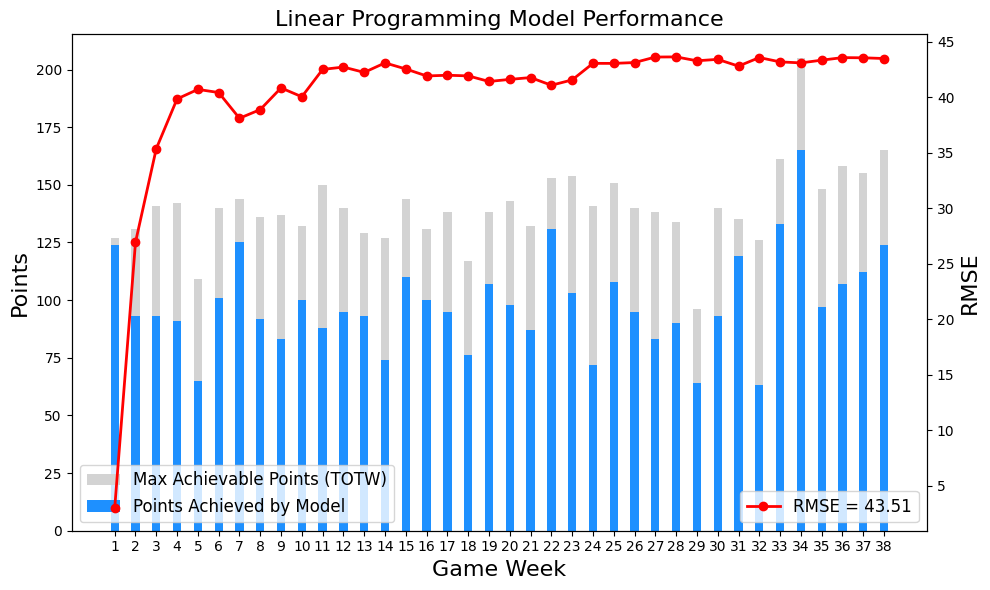

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Max achievable points (TOTW)
max_points = totw_points
indices = np.arange(1, len(max_points) + 1)
# Points achieved by the model
model_points = pred_points  

# Plotting canvas
fig, ax1 = plt.subplots(figsize=(10, 6))
bar_width = 0.4

# Bars for max achievable points
bar1 = ax1.bar(
    indices, max_points, bar_width, label="Max Achievable Points (TOTW)", color="lightgray"
)

# Bars for model points achieved (overlapping)
bar2 = ax1.bar(
    indices,
    model_points,
    bar_width,
    label="Points Achieved by Model",
    color="dodgerblue",
)

# Secondary y-axis for RMSE
ax2 = ax1.twinx()
line = ax2.plot(indices, rmse, label=f"RMSE = {round(mse, 2)}", color="red", marker="o", linewidth=2)

# Labels, title, and legend
ax1.set_xlabel("Game Week", fontsize=16,)
ax1.set_ylabel("Points", fontsize=16,)
ax2.set_ylabel("RMSE", fontsize=16,)
ax1.set_title("Linear Programming Model Performance", fontsize=16,)
ax1.set_xticks(indices)
ax1.legend(loc="lower left", fontsize=12)
ax2.legend(loc="lower right", fontsize=12)

plt.tight_layout()
plt.show()

# 5. Comparison statistics

In [109]:
# Basic statistics

from numpy import mean, std

values = []
total_pts = []
xp_pts = []
st_dev_intra = []
for i in range(38):
    values.append(squads['players'][i]['value'].sum())
    total_pts.append(squads['players'][i]['total_points'].sum())
    xp_pts.append(squads['players'][i]['xP_inter'].sum())
    st_dev_intra.append(std(squads['players'][i]['total_points']))


print(f"infer_time: {mean(infer_times)}, rmse: {mse}, mae: {mae}, mape: {mape}")
print(f"values: {mean(values)}, total_pts: {mean(total_pts)}, exp_pts: {mean(xp_pts)}")
print(f"total_pts_std: {std(total_pts)}, exp_pts_std: {std(xp_pts)}, std_intra: {mean(st_dev_intra)}")

infer_time: 0.9309796973278648, rmse: 43.510131911399306, mae: 41.55263157894737, mape: 0.2995013421096329
values: 712.6578947368421, total_pts: 98.65789473684211, exp_pts: 86.43289473684209
total_pts_std: 20.587779098276872, exp_pts_std: 17.46140961752587, std_intra: 4.969669821290607


In [ ]:
# Overlap of players from the best team (TOTW)

df_totw = pd.read_pickle('data/df_totw.pkl')
df_players = pd.DataFrame(squads['players'][0])

for i in range(1,38):
    df_players = pd.concat([df_players, pd.DataFrame(squads['players'][i])])

overlap_pct = []
for i in range(1, 39):
    common_rows = df_totw[df_totw['GW'] == i].merge(df_players[df_players['GW'] == i], how='inner')
    overlap_pct.append(len(common_rows)/11)


mean(overlap_pct)

# df_players.to_pickle('ml_results/lp_squads.pkl')

0.41148325358851673

# Benchmark best team

In [63]:
df_totw = pd.DataFrame(squads['players'][0])

In [65]:
for i in range(1,38):
    df_totw = pd.concat([df_totw, pd.DataFrame(squads['players'][i])])

In [ ]:
# df_totw.to_pickle("data/df_totw.pkl")

# Benchmark minimum team

In [77]:
df_bench_lower = pd.DataFrame(squads['players'][0])

In [79]:
for i in range(1,38):
    df_bench_lower = pd.concat([df_bench_lower, pd.DataFrame(squads['players'][i])])

In [ ]:
# df_bench_lower.to_pickle("data/df_bench_lower.pkl")